In [1]:
""" import useful functions """

# Generic
import pandas as pd
import numpy as np
import scipy
import sys
from itertools import islice, cycle
import math

# Generate data sets
from sklearn.datasets import make_blobs

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# cosmology
import pyccl as ccl


In [2]:
## EXAMPLE1: example of how to import power spectrum

"""
# import data P(k) and k for some simulation

with open('/home/c2042999/C_EEl_project/C_EEl_data/Test_sim.dat',"r") as data:
    d = np.loadtxt(data)
    d = np.transpose(d)
    z = d[0]
    k = d[1]
    Pk = d[2]

plt.plot(k[:288],Pk[:288])
plt.xscale('log')
plt.yscale('log')

del d, z, k, Pk
"""

'\n# import data P(k) and k for some simulation\n\nwith open(\'/home/c2042999/C_EEl_project/C_EEl_data/Test_sim.dat\',"r") as data:\n    d = np.loadtxt(data)\n    d = np.transpose(d)\n    z = d[0]\n    k = d[1]\n    Pk = d[2]\n\nplt.plot(k[:288],Pk[:288])\nplt.xscale(\'log\')\nplt.yscale(\'log\')\n\ndel d, z, k, Pk\n'

z is np.linspace(0.001 , 5.0 , int(1e4))

## Find binned redshift distribution (define z and output Binned_distribution(z))

In [3]:
""" Get a binned redshift distribution - defining functions """

# define the reasonable redshift distribution (not normalized yet)

def redshiftdist(z):
    
    alpha = 1.27
    beta = 1.02
    z0 = 0.5
    pz = z**alpha * np.exp(-(z / z0)**beta)                                # Redshift distribution, p(z)
    return pz

# complete binning of z so that integral of redshiftdist(z) between bins stays the same. Need redshiftdist(z) to be Normalized
# (in limit of large z linspace)

def bindist(z, n_bins):
                                                                          # have redshiftdist(z), z 
                                                                          # find bins: integrate between 0 and i redshift(z)
                                                                          #            if integral => 1/n_bin, that is a bin
                                                                          #            repeat for 2/n_bin, 3/n_bin, etc
    pz = redshiftdist(z)
    N = scipy.integrate.simps(pz, z)                                      # Normalization factor
    pz = pz/N
    j = 1
    bins = np.zeros(int(n_bins + 1))
    for i in range(len(z) - 10):
        I = scipy.integrate.simps(pz[0 : i + 10], z[0 : i + 10])
        if I >= j / n_bins:
            bins[j] = z[i + 10]
            j += 1
    bins[int(n_bins)] = z[len(z) - 1]
    bins[0] = z[0]
    return bins

# define gaussian photo-z uncertainties

def gaussianphotoz(zs , zp):
    I = np.exp(-np.power(zs - zp , 2.) / (2 * np.power(0.05 * (1 + zp) , 2.)))
    N = scipy.integrate.simps(I , zs)
    return I/(N)

# bins distribution for redshiftdist(z) in n_bins with same number of galaxies in each bin, smoothened by gaussianphotoz(zs , zp) kernel

def binning_redshiftdist(z , n_bins):
    
    N = scipy.integrate.simps(redshiftdist(z), z)

    # complete binning
    bin_edges = bindist(z, n_bins)

    # smoothing redshift distribution with gaussian kernel

    Sum = 0                                                                       # find what the sum of normalized plots is. Want this equal to Rdist
    binned_redshiftdist = np.zeros((len(bin_edges) - 1, len(z)))

    for i in range(len(bin_edges) - 1):
        Rdist_new = np.zeros(len(z))
        conv = np.zeros(len(z))

        for j in range(len(z)):                                                  # define binned redshift functions before smoothing
            if z[j] >= bin_edges[i] and z[j] <= bin_edges[i+1]:
                Rdist_new[j] = redshiftdist(z[j])/(N)
    
        for j in range(len(z)):                                                  # smoothen distributions by convolving with a gaussian kernel
            conv[j] = scipy.integrate.simps(Rdist_new * gaussianphotoz(z , z[j]) , z)
    
        binned_redshiftdist[i] = conv
    
        Sum += conv
    
    #plt.plot(zp, conv)
    return binned_redshiftdist , Sum

In [4]:
""" Get a binned redshift distribution - getting the actual distribution """

# find normalized redshift distribution

z = np.linspace(0.001 , 5.0 , int(1e4))

Rdist = redshiftdist(z)
N = scipy.integrate.simps(Rdist, z)                                    # Normalization factor
Rdist = Rdist/N

Binned_distribution = binning_redshiftdist(z , 10)[0]

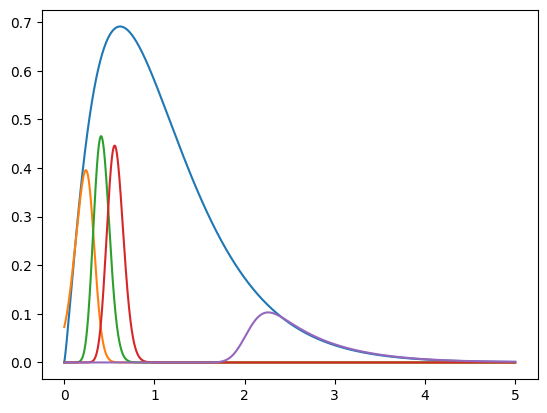

In [5]:
## TEST2: Plots to check binned redshift distribution


plt.plot(z , Rdist)
plt.plot(z ,Binned_distribution[0])
plt.plot(z ,Binned_distribution[1])
plt.plot(z ,Binned_distribution[2])
plt.plot(z ,Binned_distribution[len(Binned_distribution)-1])


## Finding C_ell

In [6]:
""" Finding C_ell_array (our training data) - defining function """

def findC_ell_array(ell_min, ell_max, ell_bin_num, cosmo, cosmo_MCMC, z, Binned_distribution):
    
    #find ell arrays and empty arrays
    
    ell = np.arange(ell_min, ell_max)
    
    # define quantities for binning C_ell
    
    ell_binned_limits = np.logspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = (bin_edge1 + bin_edge2) / 2
    ell_binned = list(islice(cycle(ell_binned), int(ell_bin_num*(len(Binned_distribution)**2 + len(Binned_distribution))/2)))
    
    B_data = np.zeros((len(cosmo),int(ell_bin_num*((len(Binned_distribution) + 1) * len(Binned_distribution) / 2))))
    # find C_ell for a range of ells, then bin these to find C_ell_array 

    #Note: this gives list of C_ell[i][j][k][ell]: ith cosmology, cross correlated over jth and kth binned redshift 
    #      distribution for each binned value of ell. 

    for i in range(len(cosmo)):
        C_ell_array = []
        
        def pk_func(k, a):
            pk_lin = ccl.linear_matter_power(cosmo[i], k, a=a)
            pk_nl = ccl.nonlin_matter_power(cosmo[i], k=k, a=a)
            pk_fid = ccl.linear_matter_power(cosmo_MCMC, k, a=a)
            P_delta = (pk_nl/pk_lin) * pk_fid
            return P_delta
        
        P_delta2D = ccl.pk2d.Pk2D.from_function(pkfunc=pk_func, is_logp=False)
        
        for j in range(len(Binned_distribution)):
            for k in range(len(Binned_distribution)):
                if k > j:
                    break
                tracer1 = ccl.WeakLensingTracer(cosmo[i], dndz=(z, Binned_distribution[j]))        # TODO normalization
                tracer2 = ccl.WeakLensingTracer(cosmo[i], dndz=(z, Binned_distribution[k]))
                C_ell = ccl.angular_cl(cosmo[i], tracer1, tracer2, ell, p_of_k_a=P_delta2D)        # uses non-linear matter power spectrum stored in `cosmo`

                # bin ell
                bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(ell, C_ell, statistic='mean', 
                                                                               bins= ell_binned_limits)
    
                C_ell_array = np.append(C_ell_array, bin_means)
        B_data[i] = C_ell_array
    return ell_binned, B_data

In [7]:
""" define cosmological parameters """

c = 3e5                                                                  # km/s

cosmo_MCMC = ccl.Cosmology(Omega_c = 0.25, 
                      Omega_b = 0.05, 
                      h = 0.7, 
                      n_s = 0.95,
                      sigma8 = 0.8, 
                      transfer_function='bbks',
                      matter_power_spectrum='linear')


for k in range(2):
    for i in range(2):
        for j in range(2):
            if i==0 and j==0 and k==0:
                cosmo = ccl.Cosmology(Omega_c = 0.245 + (0.005 * i), 
                          Omega_b = 0.05, 
                          h = 0.7, 
                          n_s = 0.90 + 0.05 * j,
                          sigma8 = 0.75 + 0.05 * k, 
                          transfer_function='bbks')
            else:
                cosmo = np.append(cosmo, ccl.Cosmology(Omega_c = 0.245 + (0.005 * i), 
                          Omega_b = 0.05, 
                          h = 0.7, 
                          n_s = 0.90 + 0.05 * j,
                          sigma8 = 0.7 + 0.1 * k, 
                          transfer_function='bbks'))

print(len(cosmo))

8


In [8]:
""" Create training data: find P_del for a set of 9 power spectra with different cosmologies """

""" -- NOTES on C_ell --
# redshift distribution is Binned_distribution from above.
# binned over 10 redshift distributions. That means that C_ell[i][j][k] is the C_ell for the ith cosmology, cross correlated over
# jth and kth redshift distribution, as a function of ell."""

# define ell and C_ell shapes 

ell_min = 2
ell_max = 2060

# define quantities for binning of ell

ell_bin_num = 18

# find C_ell for non-linear matter power spectrum

C_ell_data = findC_ell_array(ell_min, ell_max, ell_bin_num, cosmo, cosmo_MCMC, z, Binned_distribution)

ell = C_ell_data[0]
B_data = C_ell_data[1]

del C_ell_data

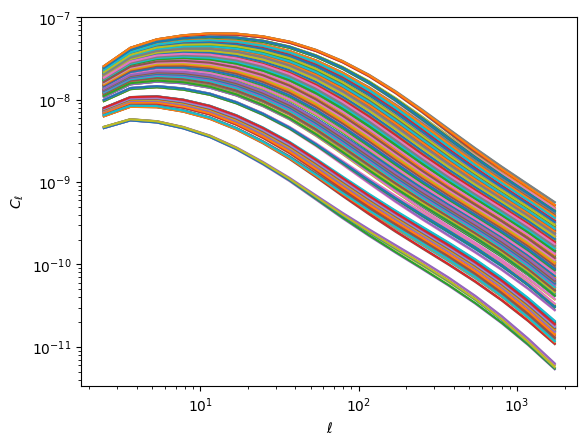

In [9]:
## TEST3: Plot C_ell to see if shapes are reasonable

for i in range(len(B_data)):
    for j in range(int(len(B_data[0])/ell_bin_num) - 1):
        plt.plot(ell[j*ell_bin_num:(j+1)*ell_bin_num], B_data[i][j*ell_bin_num:(j+1)*ell_bin_num])


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()



# comment: sigma8 changes the y intercept (as sigma8 increases the value of y-intercept increases
#          OmegaM changes the power spectrum behaviour at high P (as OmegaM increases Cl increases at high l)

In [10]:
""" Finding C_ell_array linear at each MCMC step - defining function """

def findC_ell_array_linear(ell_min, ell_max, ell_bin_num, cosmoMCMC, z, Binned_distribution):

    #find ell arrays and empty arrays
    
    ell = np.arange(ell_min, ell_max)
    C_ell_array = []
    
    # define quantities for binning C_ell

    ell_binned_limits = np.logspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = (bin_edge1 + bin_edge2) / 2

    # find C_ell for a range of ells, then bin these to find C_ell_array 

    #Note: this gives list of C_ell[i][j][k][ell]: ith cosmology, cross correlated over jth and kth binned redshift 
    #      distribution for each binned value of ell. 

    for j in range(len(Binned_distribution)):
        for k in range(len(Binned_distribution)):
            if k > j:
                break
            tracer1 = ccl.WeakLensingTracer(cosmoMCMC, dndz=(z, Binned_distribution[j]))
            tracer2 = ccl.WeakLensingTracer(cosmoMCMC, dndz=(z, Binned_distribution[k]))
            C_ell = ccl.angular_cl(cosmoMCMC, tracer1, tracer2, ell)
            
            # bin ell
            bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(ell, C_ell, statistic='mean', 
                                                                           bins= ell_binned_limits)
    
            C_ell_array = np.append(C_ell_array, bin_means)

    return C_ell_array

In [11]:
"""Find C_ell with linear matter power spectrum"""

# ell and C_ell shapes, binning taken from above to be ell_min = 2, ell_max = 2060, ell_bin_num = 18

# find C_ell

M_data = findC_ell_array_linear(ell_min, ell_max, ell_bin_num, cosmo_MCMC, z, Binned_distribution)

Text(0, 0.5, '$\\frac{C^{00}_{NL}(\\ell)}{C^{00}_{Linear}(\\ell)} - 1$')

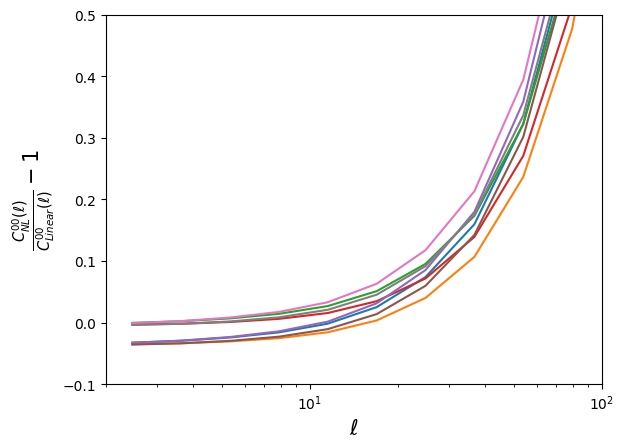

In [12]:
# TEST5: Plot processed data to compare with Huang et al 2020

frac = (B_data / M_data) - 1

plt.xscale('log')
plt.ylim(-0.1,0.5)
plt.xlim(2,1e2)
for i in range(len(cosmo)):
    plt.plot(ell[0:ell_bin_num],frac[i][0:ell_bin_num])

plt.xlabel(r'$\ell$', size = 15)
plt.ylabel(r'$\frac{C^{00}_{NL}(\ell)}{C^{00}_{Linear}(\ell)} - 1$', size = 15)

Text(0.5, 1.0, 'Cosmology: $\\sigma_8$ = 0.8 + -0.05$j$, $n_s$ = 0.9 + 0.05$i$ \n $\\ell_{min}$ = 2, $\\ell_{max}$ = 2060')

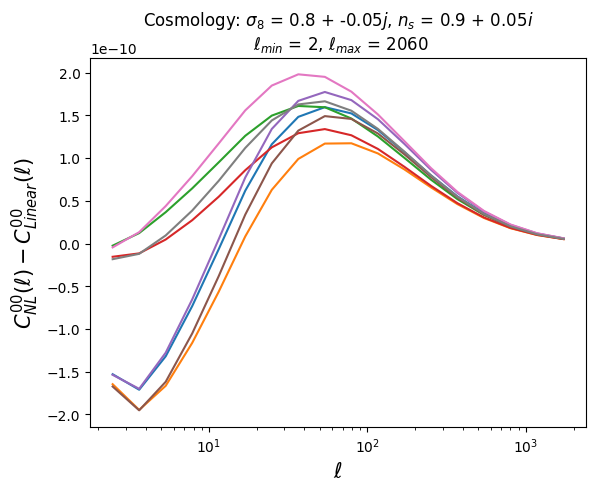

In [13]:
# TEST5: Plot processed data to compare with Huang et al 2020

sub = (B_data - M_data) 

plt.xscale('log')
#plt.ylim(0,0.5)
for i in range(len(cosmo)):
    plt.plot(ell[0:ell_bin_num],sub[i][0:ell_bin_num])
    
plt.xlabel(r'$\ell$', size = 15)
plt.ylabel(r'$C^{00}_{NL}(\ell) - C^{00}_{Linear}(\ell)$', size = 15)
plt.title("Cosmology: $\sigma_8$ = %1.1f + %1.2f$j$, $n_s$ = %1.1f + %1.2f$i$ \n $\ell_{min}$ = %i, $\ell_{max}$ = %i" \
          %(cosmo[0]["sigma8"], cosmo[1]["sigma8"] - cosmo[0]["sigma8"], cosmo[0]["n_s"], cosmo[3]["n_s"] - cosmo[0]["n_s"], ell_min, ell_max))

#plt.savefig('differenceCells.pdf')

## Finding PCA components

PCA conventions in Python

A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12
\end{bmatrix}$ = [[a00, a01, a02], [a10, a11, a12]], with aij = A[i][j]

A[0] is first row, A[:][0] is first column

len(A) = number of rows, len(A[0]) = number of columns

AxB = np.matmul(A,B)

for B = $\begin{bmatrix}
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$, np.append(A,B, axis = 0) = A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12\\
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$ 

In [14]:
# Write out the difference matrix
Delta = B_data / M_data - 1

print("Size of difference matrix Delta = ", Delta.shape)

Size of difference matrix Delta =  (8, 990)


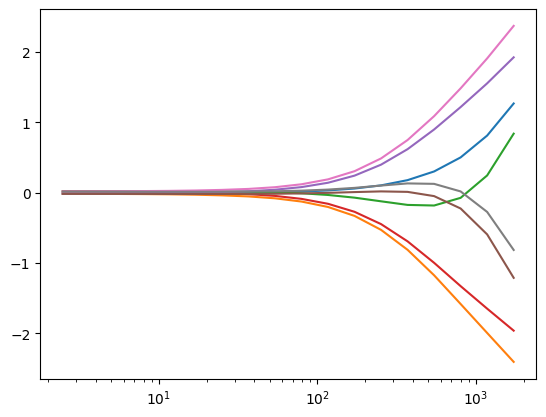

In [15]:
Delta_centered = np.zeros((len(Delta),len(Delta[0])))
for i in range(len(Delta[0])):
    offset = np.mean(Delta.T[i])
    Delta_centered[:,i] = Delta[:,i] - offset


plt.xscale('log')
#plt.ylim(0,0.5)
for i in range(len(cosmo)):
    plt.plot(ell[0:ell_bin_num],Delta_centered[i][0:ell_bin_num])

In [16]:
# Perform PCA with sklearn (Choose n_components to keep)
pca = PCA()

# Apply sklearn PCA method
sklearn_PCA = pca.fit(Delta)

# Find vectors in direction of PCs (normalized ,positive)
PCAs_vects_sklearn = sklearn_PCA.components_
print("PCA eigenvector array size = ", PCAs_vects_sklearn.shape)

# Find eigenvalues for each PC
PCAs_eigenvals_sklearn = sklearn_PCA.singular_values_

print("eigenvalues = ", PCAs_eigenvals_sklearn)
#find PC vectors with eigenvalues as norm

Usklearn = np.matmul(np.diag(PCAs_eigenvals_sklearn), np.matrix(PCAs_vects_sklearn))

print("PCA norm eigenvector array size = ",Usklearn.shape)

PCA eigenvector array size =  (8, 990)
eigenvalues =  [2.71599361e+01 4.10149230e+00 1.01726867e+00 5.56110466e-02
 1.81118864e-02 7.10731972e-03 1.25331505e-03 3.41683214e-14]
PCA norm eigenvector array size =  (8, 990)


In [17]:
# Perform PCA with numpy.linalg.svd

Usvd, s, vh = np.linalg.svd(Delta.T, full_matrices=True)

Usvd = Usvd.T

print("eigenvalues = ", s)

print("shape U = ", Usvd.shape)
print("shape sigma = ", s.shape)
print("shape V_transpose = ", vh.shape)

eigenvalues =  [3.62804828e+02 5.81295971e+00 1.27359708e+00 6.25814363e-01
 2.18472759e-02 8.63693185e-03 5.28180759e-03 1.22676896e-03]
shape U =  (990, 990)
shape sigma =  (8,)
shape V_transpose =  (8, 8)


In [18]:
def findU_PCAmethod(Delta):
    
    # find eigenvectors and eigenvalues of AAt = Delta*Deltat
    AAt = np.matmul(Delta,np.transpose(Delta))
    eigenvals,eigenvects = np.linalg.eig(AAt)

    eigenvals = eigenvals.real
    eigenvects = eigenvects.real

    # Put eigenvectors and eigenvalues in right order, find U
    #composedmatrix = np.array(np.append([eigenvals],np.transpose(eigenvects), axis = 0))
    #orderedmatrix = composedmatrix[:, (-composedmatrix)[0].argsort()]
    #U = np.transpose(orderedmatrix[1:])
    return eigenvects, eigenvals

In [19]:
""" PCA decomposition"""

# Find Delta as 990 rows and 9 columns
manual_soln = findU_PCAmethod(np.transpose(Delta))
Umanual = manual_soln[0].T
eigenval_manual = manual_soln[1]
print("eigenvalues = ", eigenval_manual[:8]**0.5)


eigenvalues =  [3.62804828e+02 5.81295971e+00 1.27359708e+00 6.25814363e-01
 2.18472759e-02 8.63693184e-03 5.28180768e-03 1.22676947e-03]


In [20]:
print("full eigenvalues = ", np.abs(eigenval_manual)**0.5)

full eigenvalues =  [3.62804828e+02 5.81295971e+00 1.27359708e+00 6.25814363e-01
 2.18472759e-02 8.63693184e-03 5.28180768e-03 1.22676947e-03
 7.78788673e-07 7.78788673e-07 2.70499236e-06 2.62695495e-06
 2.45126689e-06 2.45126689e-06 1.68446295e-06 1.68446295e-06
 1.96927848e-06 1.96927848e-06 1.72988130e-06 1.72988130e-06
 1.39488668e-06 1.39488668e-06 6.94751194e-07 6.94751194e-07
 1.77591926e-06 1.77591926e-06 1.44458967e-06 1.44458967e-06
 7.29973691e-07 7.29973691e-07 1.56640000e-06 1.56640000e-06
 1.65133383e-06 1.65133383e-06 1.53602335e-06 1.52396005e-06
 1.27380462e-06 1.27380462e-06 1.45216940e-06 1.45216940e-06
 1.39310037e-06 1.39310037e-06 1.39627399e-06 1.39627399e-06
 1.36743129e-06 6.47029600e-07 6.47029600e-07 1.23350530e-06
 1.23350530e-06 4.26846381e-07 4.26846381e-07 1.35068009e-06
 1.29438723e-06 1.24452470e-06 1.24452470e-06 1.08474683e-06
 1.08474683e-06 8.93169159e-07 8.93169159e-07 1.24401546e-06
 7.81242438e-07 7.81242438e-07 9.94653351e-07 9.94653351e-07
 1.1

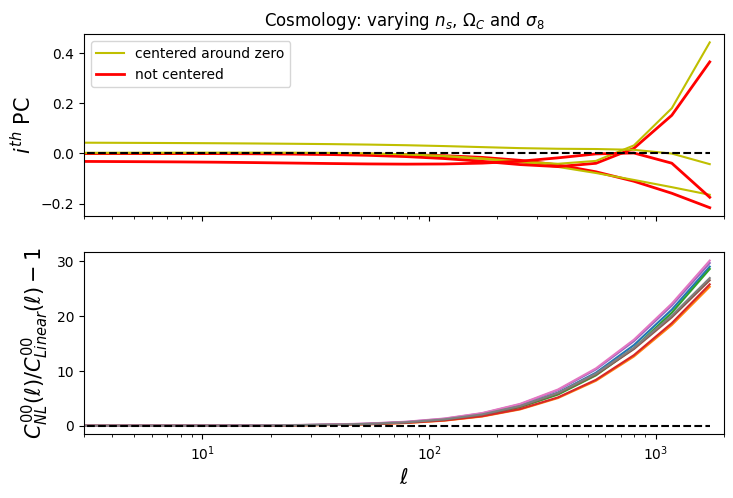

In [21]:
"""Plot PCA components for different methods as a function of ell, and compare with angular power spectra"""

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False,figsize=(8, 5))

for i in range(3):
    #ax1.plot(ell[0:ell_bin_num], Umanual[i][0:ell_bin_num], color = "b", label = "Manual method")
    ax1.plot(ell[0:ell_bin_num], -Usvd[i][0: ell_bin_num], color = "r" ,linewidth=2)
    #ax1.plot(ell[0:ell_bin_num], Usklearn[i,0:ell_bin_num], label = "sklearn method", color = "y")
    ax1.plot(ell[0:ell_bin_num], PCAs_vects_sklearn[i,0:ell_bin_num], color = "y")
    
ax1.plot(ell[0:ell_bin_num], np.zeros(len(ell[0:ell_bin_num])), "k--")

line2, = ax1.plot(ell[0:ell_bin_num], PCAs_vects_sklearn[0,0:ell_bin_num], label = "centered around zero", color = "y")
line1, = ax1.plot(ell[0:ell_bin_num], -Usvd[0][0: ell_bin_num], color = "r" , label = "not centered", linewidth=2)
ax1.legend()

line1.remove()
line2.remove()

ax1.set_ylabel(r'$i^{th}$ PC', size = 15)
ax1.set_title("Cosmology: varying $n_s$, $\Omega_C$ and $\sigma_8$")
plt.xscale("log")


#plt.ylim(0,0.5)
for i in range(len(cosmo)):
    ax2.plot(ell[0:ell_bin_num],Delta[i][0:ell_bin_num])
ax2.plot(ell[0:ell_bin_num], np.zeros(len(ell[0:ell_bin_num])), "k--")

ax2.set_ylabel(r'$C^{00}_{NL}(\ell) / C^{00}_{Linear}(\ell) - 1$', size = 15)
ax2.set_xlabel(r'$\ell$', size = 15)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)

ax1.set_xlim(3,2e3)


#plt.savefig('PCcompare.pdf' , bbox_inches='tight')
plt.show()



## Testing PCA components with mock new data vector

In [22]:
"""Create mock data vector"""

# define ell and C_ell shapes 

ell_min_mockdata = 2
ell_max_mockdata = 2060

# define quantities for binning of ell

ell_bin_num_mockdata = 18

# Define cosmology

cosmo = [ccl.Cosmology(Omega_c = 0.26, 
                          Omega_b = 0.05, 
                          h = 0.7, 
                          n_s = 1.05,
                          sigma8 = 0.7, 
                          transfer_function='bbks'),
         ccl.Cosmology(Omega_c = 0.26, 
                          Omega_b = 0.05, 
                          h = 0.7, 
                          n_s = 1.05,
                          sigma8 = 0.7, 
                          transfer_function='bbks')]
# find C_ell for non-linear matter power spectrum - use same z binned dist

C_ell_mockdata = findC_ell_array(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, cosmo, cosmo_MCMC, z, Binned_distribution)

ell_mockdata = C_ell_mockdata[0]
B_mockdata = C_ell_mockdata[1][0]

del C_ell_mockdata

M_mockdata = findC_ell_array_linear(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, cosmo_MCMC, z, Binned_distribution)


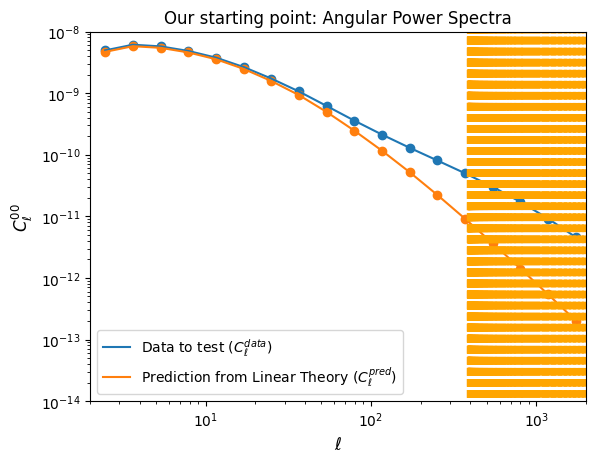

In [23]:
"""Plot angular power spectra with expected scale cuts. Explanatory plots"""

plt.xscale('log')
plt.yscale('log')
plt.plot(ell_mockdata[0:18],B_mockdata[0:18], label = "Data to test ($C^{data}_{\ell}$)")
plt.scatter(ell_mockdata[0:18],B_mockdata[0:18])
plt.plot(ell_mockdata[0:18],M_mockdata[0:18], label = "Prediction from Linear Theory ($C^{pred}_{\ell})$")
plt.scatter(ell_mockdata[0:18],M_mockdata[0:18])
plt.xlim(2,2000)
plt.ylim(1e-14,1e-8)

for i in np.logspace(-2,0,200):
    plt.plot((ell_mockdata[13] + i*(ell_mockdata[17] +3e2 - ell_mockdata[13]))*np.ones(10), \
             np.linspace(-1,1e-7,10), "--", color = "orange")


    
plt.xlabel(r'$\ell$', size = 12)
plt.ylabel(r'$C^{00}_\ell$', size = 12)
plt.title("Our starting point: Angular Power Spectra")

plt.legend()
#plt.savefig('PCAexplain_5.pdf')
plt.show()


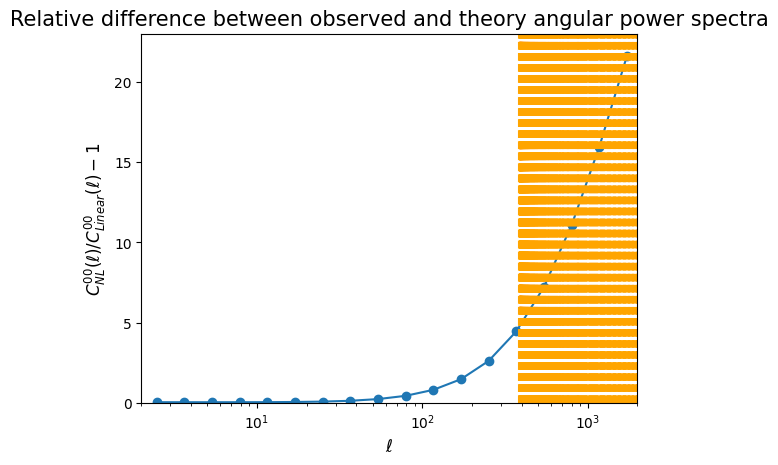

In [24]:
"""Plot difference in angular power spectra with expected scale cuts. Explanatory plots"""

plt.xscale('log')
plt.plot(ell[0:18],(B_mockdata / M_mockdata - 1)[0:18])
plt.scatter(ell[0:18],(B_mockdata / M_mockdata - 1)[0:18])
plt.ylim(0,23)
plt.xlim(2,2000)

for i in np.logspace(-2,0,200):
    plt.plot((ell_mockdata[13] + i*(ell_mockdata[17] +3e2 - ell_mockdata[13]))*np.ones(10),\
             np.linspace(0,23,10), "--", color = "orange")


plt.xlabel(r'$\ell$', size = 12)
plt.ylabel(r'$C^{00}_{NL}(\ell) / C^{00}_{Linear}(\ell) - 1$', size = 12)
plt.title(r"Relative difference between observed and theory angular power spectra", size = 15)

#plt.savefig('PCAexplain_4.pdf')
plt.show()

In [25]:
newdata = np.matmul(Usvd, (B_mockdata / M_mockdata - 1).T)
"""
## CHECK that I am doing the dot product the right way round
testdata = []
for i in range(len(Usvd)):
    testdata = np.append(testdata, np.dot(Usvd[i], Delta[0].T))
"""
print(len(newdata))

990


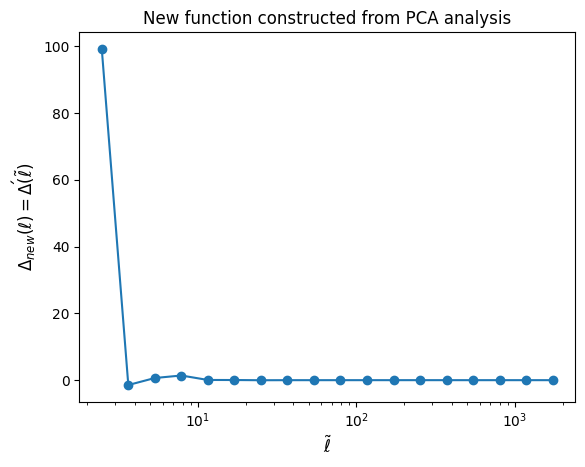

In [26]:
"""Plot rotated angular power spectra used to make U_svd. Explanatory plots"""

"""
plt.plot(ell[0:18],testdata.T[0:18])
plt.scatter(ell[0:18],testdata.T[0:18], marker = "x")
"""
plt.xscale('log')
plt.plot(ell[0:18],newdata.T[0:18])
plt.scatter(ell[0:18],newdata.T[0:18])



plt.xlabel(r'$\tilde{\ell}$', size = 12)
plt.ylabel(r'$\Delta_{new}(\ell) = \Delta\'(\tilde{\ell})$', size = 12)
plt.title("New function constructed from PCA analysis")

#plt.savefig('PCAexplain_3.pdf')

plt.show()

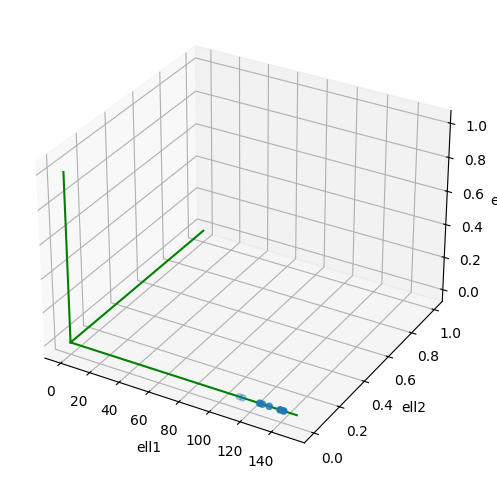

In [27]:
""" Plot of data and PC modes in rotated space. The data points will align along the first few eigenvectors"""

rotated_eigenvect = np.matmul(Usvd, Delta.T)

fig = plt.figure(figsize=(6,6))

ax = plt.axes(projection='3d')
ax.scatter(rotated_eigenvect.T[:,0], rotated_eigenvect.T[:,10], rotated_eigenvect.T[:,20], marker='o')

mean_ell1 = np.mean(rotated_eigenvect.T[:,0])
mean_ell2 = np.mean(rotated_eigenvect.T[:,10])
mean_ell3 = np.mean(rotated_eigenvect.T[:,20])

plt3 = PCAs_vects_sklearn.T
plt2 = Usvd.T

#for i in range(3):
    #ax.plot([plt3[0,i]/1e6 , 0],[plt3[1,i]/1e6, 0],[plt3[2,i]/1e6 , 0], color = "r")
    #ax.plot([plt2[0,i]/1e6 , 0],[plt2[1,i]/1e6, 0],[plt2[2,i]/1e6 , 0], color = "b")

ax.plot([150 , 0],[0, 0],[0 , 0], color = "g")
ax.plot([0 , 0],[1, 0],[0 , 0], color = "g")
ax.plot([0 , 0],[0, 0],[1 , 0], color = "g")

ax.set_xlabel('ell1')
ax.set_ylabel('ell2')
ax.set_zlabel('ell3')

plt.show()

In [28]:
"""Data to put in MCMC calculation"""

Cutdata = np.matmul(Usvd[8:], (B_mockdata / M_mockdata - 1).T)